# Lecture 5: simulating quantum noise

<center><img src="./figures/dall-e/merlion_noise.png" alt="drawing" width="400"/></center>
<center><strong>Fig. 5:</strong> Merlion suffering noise [DALL-E].</center>

## Introduction

In real life scenarios, quantum computers are imperfect and prone to noise. Some of the noise sources can be:
- **decoerence**, which corresponds to the loss of the quantum properties of the system, usually due to some interaction with the external environment;
- **thermal noise**, which affects in particular systems sensitive to temperature;
- **control errors**, due to some imperfections in the laboratory tools (cables, control boards, etc.);
- **cross-talk**, which happens when some operation we apply to a single qubit unintentionally affect the neighbouring qubits;
- **quantum state leakage**, which is the possibility to access some undesired energy level. It can happen for example using superconducting qubits, which are in principle N-levels systems prepared to isolate the first two energy levels.

More in general, a combination of these phenomena can affect a real quantum device, leading to a simple but relevant problem: the expected results are corrupted. 

In `qibo`, we can simulate noisy systems and implement some strategies to take this problem into account, cleaning our results from undesired corruptions. 

In the following:

1. we define a simple problem, consisting in calculating the expected value of a target observable over the final state we obtain executing a quantum circuit;
2. we compute the exact result with noiseless simulation;
3. we add noise to the circuit and compute the noisy result;

#### 1. Problem definition

We consider as an example a simple quantum system of three qubits, on which we aim to apply some rotations and then compute the expectation value of an observable composed of Pauli's.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import qibo
from qibo import Circuit, gates, hamiltonians

from scripts import plotscripts

In [4]:
qibo.set_backend("qibojit")

[Qibo 0.2.4|INFO|2024-01-14 16:10:56]: Using qibojit (numba) backend on /CPU:0


In [5]:
nqubits = 3
nlayers = 3

c = Circuit(nqubits)
for l in range(nlayers):
    for q in range(nqubits):
        c.add(gates.RY(q=q, theta=0))
        c.add(gates.RZ(q=q, theta=0))
    for q in range(0, nqubits-1, 1):
        c.add(gates.CNOT(q0=q, q1=q+1))
c.add(gates.M(*range(nqubits)))

MeasurementResult(qubits=(0, 1, 2), nshots=0)

In [6]:
print(c.draw())

q0: ─RY─RZ─o───RY─RZ─o───RY─RZ─o───M─
q1: ─RY─RZ─X─o─RY─RZ─X─o─RY─RZ─X─o─M─
q2: ─RY─RZ───X─RY─RZ───X─RY─RZ───X─M─


Now the circuit is set up and we can fix its action by injecting a specific list of rotational angles. 

We get the numbers of contained parameters:

In [7]:
nparams = len(c.get_parameters())

And then we generate a well defined set of angles.

In [9]:
angles = np.linspace(0, 2*np.pi, nparams)
print(angles)

[0.         0.36959914 0.73919827 1.10879741 1.47839654 1.84799568
 2.21759481 2.58719395 2.95679309 3.32639222 3.69599136 4.06559049
 4.43518963 4.80478876 5.1743879  5.54398704 5.91358617 6.28318531]


In [10]:
# set the angles into the circuit
c.set_parameters(angles)

Now we have a quantum circuit composed of rotations and some CNOT gates. We want to use it to compute some calculations. 

To do this, we can define an observable $\mathcal{O}$, for which we calculate:

$$ \langle \mathcal{O} \rangle \equiv \langle 0 | U^{\dagger}\, \mathcal{O}\, U | 0 \rangle \\. $$

We make the choice:

$$ \mathcal{O} = - \sum_{i=0}^N Z_i \\.$$

In [14]:
# observable definition
obs = hamiltonians.Z(nqubits=nqubits)
print(obs.matrix)

[[-3.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -1.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -1.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -1.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  1.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j -0.-0.j  3.-0.j]]


#### 2. Computing the exact expectation value

(0.0915-0.18058j)|000> + (-0.29392-0.4377j)|001> + (0.10396+0.10098j)|010> + (0.39786+0.40424j)|011> + (0.05154-0.09481j)|100> + (-0.23167-0.12098j)|101> + (-0.24672+0.09257j)|110> + (-0.39625-0.17869j)|111>


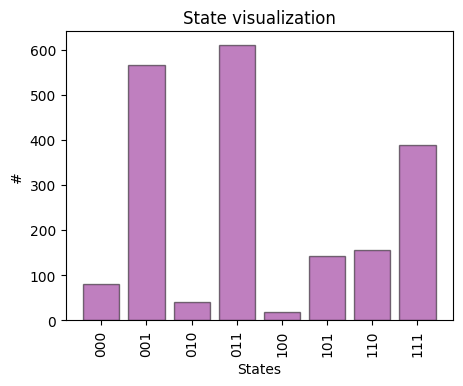

In [15]:
# execute the circuit
final_state = c(nshots=2000)

# print final state
print(final_state)

# collect and visualize frequencies
frequencies = final_state.frequencies(binary=True)
plotscripts.visualize_states(frequencies)

In [19]:
# compute the expected value
exp_value = obs.expectation_from_samples(frequencies)

print(exp_value)

0.6020000000000001


#### 3. Add noise to the system

Various different ways to simulate noise exist in `qibo`, but in this lecture we focus on one of them. 

Let me introduce before the Pauli noise channel, which is used here to corrupt the circuit. If we consider a quantum state represented by the density matrix $\rho$, the effect of a Pauli noise channel on the state is

$$ \mathcal{E}(\rho) = \biggl(1 - \sum_{k=0}p_k\biggr)\rho + \sum_k P_k \,\rho\, P_k \\,
$$

where $P_k$ is the $k$-th Pauli string and $p_k$ is the probability of applying $P_k$. 

This channel allows to formalize a corruption of the state $\rho$ in which each Pauli represents some specific error which can occurr: for example, the Pauli X and Z respectively represent a bit-flip error and a phase-flip error in the qubit state.

We are going to use the `circuit.with_pauli_noise` method, which consists in applying a Pauli noise channel after every gate of the circuit. 

In [20]:
# define the Pauli's probabilities for each qubit of the system
noise_map = {
    0: list(zip(["X", "Z"], [0.007, 0.008])),
    1: list(zip(["Y", "Z"], [0.01, 0.005])),
    2: list(zip(["X", "Z"], [0.008, 0.007]))
}

noisy_c = c.with_pauli_noise(noise_map)

Let's print the new face of the circuit, with the Pauli noise channel after each gate.

In [21]:
print(noisy_c.draw())

q0: ─RY─PN─RZ─PN─o─PN───RY─PN─RZ─PN────o─PN───RY─PN─RZ─PN────o─PN──────M─
q1: ─RY─PN─RZ─PN─X─PN─o─PN─RY─PN─RZ─PN─X─PN─o─PN─RY─PN─RZ─PN─X─PN─o─PN─M─
q2: ─RY─PN─RZ─PN──────X─PN─RY─PN─RZ─PN──────X─PN─RY─PN─RZ─PN──────X─PN─M─


In [22]:
# set the parameters

noisy_c.set_parameters(angles)

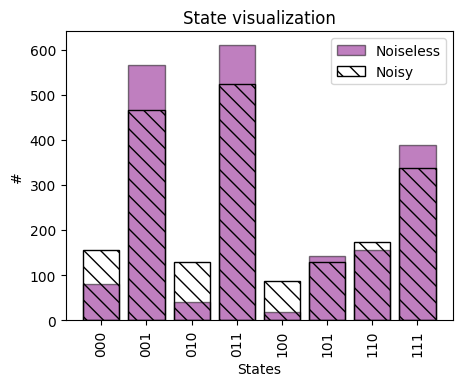

In [23]:
# execute the circuit
noisy_final_state = noisy_c(nshots=2000)

# collect and visualize frequencies
noisy_frequencies = noisy_final_state.frequencies(binary=True)
plotscripts.visualize_states(frequencies, noisy_frequencies)

As final step of this lecture 4, let's compute the expectation value of $\mathcal{O}$ over the noisy final state.

In [25]:
noisy_exp = obs.expectation_from_samples(noisy_frequencies)

print(f"Noiseless expectation value: {exp_value}")
print(f"Noisy expectation value: {noisy_exp}")

Noiseless expectation value: 0.6020000000000001
Noisy expectation value: 0.3440000000000001


<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> what is happening to the system? why is the expected value of $Z$ decreasing? What happens if you increase the magnitude of the noise?
</div>